# Plot Viual Odometry

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from copy import copy

def transform(t_x, t_y, t_z, r_x, r_y, r_z, r_w):
    return np.asarray(
        [[1-2*r_y**2-2*r_z**2, 2*r_x*r_y-2*r_z*r_w, 2*r_x*r_z+2*r_y*r_w, t_x],
         [2*r_x*r_y+2*r_z*r_w, 1-2*r_x**2-2*r_z**2, 2*r_y*r_z-2*r_x*r_w, t_y],
         [2*r_x*r_z-2*r_y*r_w, 2*r_y*r_z+2*r_x*r_w, 1-2*r_x**2-2*r_y**2, t_z],
         [0,0,0,1]])
# https://en.wikipedia.org/wiki/Rotation_matrix#General_rotations

In [2]:
df = pd.read_csv("/home/torsten/ms/data/rosbag2_old_zoo_a_09_29/vo.csv")
df

,timestamp,t_x,t_y,t_z,r_x,r_y,r_z,r_w
0,1695990713820,2.506663e-07,-1.400795e-07,-6.415706e-07,0.000000,0.000000,0.000000,1.0
1,1695990713920,-3.637385e-06,6.480047e-06,1.130139e-05,0.000000,0.000000,0.000000,1.0
2,1695990714025,7.698286e-12,4.291012e-13,-8.085976e-12,0.000000,0.000000,0.000000,1.0
3,1695990714157,-7.046061e-06,9.321909e-06,3.090860e-05,0.000000,0.000000,0.000000,1.0
4,1695990714240,-1.055482e-05,-3.268929e-03,-1.026319e-02,-0.000126,0.000004,-0.000014,1.0
...,...,...,...,...,...,...,...,...
4849,1695991148158,6.211788e-04,-2.946135e-04,-2.059732e-03,-0.000027,-0.000027,-0.000023,1.0
4850,1695991148258,-1.311423e-12,-2.684758e-11,-7.859002e-11,0.000000,0.000000,0.000000,1.0
4851,1695991148385,5.322378e-07,6.815245e-07,1.592522e-06,0.000000,0.000000,0.000000,1.0
4852,1695991148446,3.102936e-04,-1.646045e-04,-2.716617e-03,-0.000029,0.000005,-0.000022,1.0


In [3]:
df_kf = pd.read_csv("/home/torsten/ms/data/rosbag2_old_zoo_a_09_29/kf.csv")
#df_kf = df_kf.iloc[1:]
df_kf

,timestamp,t_x,t_y,t_z,r_x,r_y,r_z,r_w
0,1695990737051,0.171675,-0.129543,2.047825,-0.023626,0.005716,-0.006400,0.999686
1,1695990739138,0.009562,-0.000850,2.047500,0.005489,0.039878,-0.016790,0.999049
2,1695990741386,-0.055806,-0.002220,2.043437,0.008806,-0.019250,-0.015220,0.999660
3,1695990743534,-0.002435,0.025109,2.125204,-0.012032,0.000079,0.008907,0.999888
4,1695990745518,-0.014167,0.027358,2.050254,-0.014214,0.003172,0.005619,0.999878
...,...,...,...,...,...,...,...,...
202,1695991129348,-0.132334,-0.024859,2.119131,0.000481,-0.035389,-0.006417,0.999353
203,1695991131584,-0.122832,-0.025553,2.025272,-0.005799,-0.073532,0.015050,0.997163
204,1695991133601,-0.075399,-0.039348,1.998978,-0.004275,-0.004839,-0.018717,0.999804
205,1695991135719,0.222848,-0.052065,2.016642,0.005436,0.065556,-0.024354,0.997537


In [4]:
poses = []
poses_kf = []
last_tf = transform(0,0,0,0,0,0,1)

vo_T_robot = np.asarray([[ 0,  0, 1, 0],
                         [-1,  0, 0, 0],
                         [ 0, -1, 0, 0],
                         [ 0,  0, 0, 1]], dtype=float)

vTr_inv = np.linalg.inv(vo_T_robot)

#"""
for i, row in df.iterrows():
    tf = transform(row["t_x"], row["t_y"], row["t_z"], row["r_x"], row["r_y"], row["r_z"], row["r_w"])
    # Convert to robot frame
    tf = np.matmul(vo_T_robot, tf)
    tf = np.matmul(tf, vTr_inv)
    last_tf = np.matmul(last_tf, tf)
    poses.append(copy(last_tf))

# Get transform of first keyframe
for index, row in df.iterrows():
    if row["timestamp"] >= df_kf.iloc[0, 0]:
        print(row["timestamp"])
        print(df_kf.iloc[0, 0])
        last_tf = poses[index]
        print(index)
        print(last_tf)
        break

#last_tf = transform(0,0,0,0,0,0,1)
for i, row in df_kf.iloc[1:].iterrows():
    tf = transform(row["t_x"], row["t_y"], row["t_z"], row["r_x"], row["r_y"], row["r_z"], row["r_w"])
    # Convert to robot frame
    tf = np.matmul(vo_T_robot, tf)
    tf = np.matmul(tf, vTr_inv)
    last_tf = np.matmul(last_tf, tf)
    poses_kf.append(copy(last_tf))
#"""

    
print(last_tf)


    

1695990737052.0
1695990737051
313
[[ 0.99964664  0.0133355   0.02299496  2.7680512 ]
 [-0.01346961  0.99989311  0.0056871  -0.08872158]
 [-0.02291666 -0.00599483  0.99971941  0.03239573]
 [ 0.          0.          0.          1.        ]]
[[-0.83944756 -0.54059265 -0.05557493 -1.81353123]
 [ 0.53342144 -0.83919699  0.10588269 40.00679531]
 [-0.10387765  0.05923827  0.99282449 14.70199379]
 [ 0.          0.          0.          1.        ]]


In [5]:
"""
poses.append(transform(0,0,0,0,0,0,1))

for i in range(3):
    tf =transform(0.2,0,0,0,0.707,0,0.707)
    last_tf = np.matmul(tf, last_tf)
    poses.append(copy(last_tf))

#poses.append(transform(2,0,0,0,0,0,1))
#poses.append(transform(3,0,0,0,0,0,1))
"""


'\nposes.append(transform(0,0,0,0,0,0,1))\n\nfor i in range(3):\n    tf =transform(0.2,0,0,0,0.707,0,0.707)\n    last_tf = np.matmul(tf, last_tf)\n    poses.append(copy(last_tf))\n\n#poses.append(transform(2,0,0,0,0,0,1))\n#poses.append(transform(3,0,0,0,0,0,1))\n'

In [6]:
poses = np.asarray(poses)
poses.shape

(4854, 4, 4)

In [7]:
poses_kf = np.asarray(poses_kf)
poses_kf.shape

(206, 4, 4)

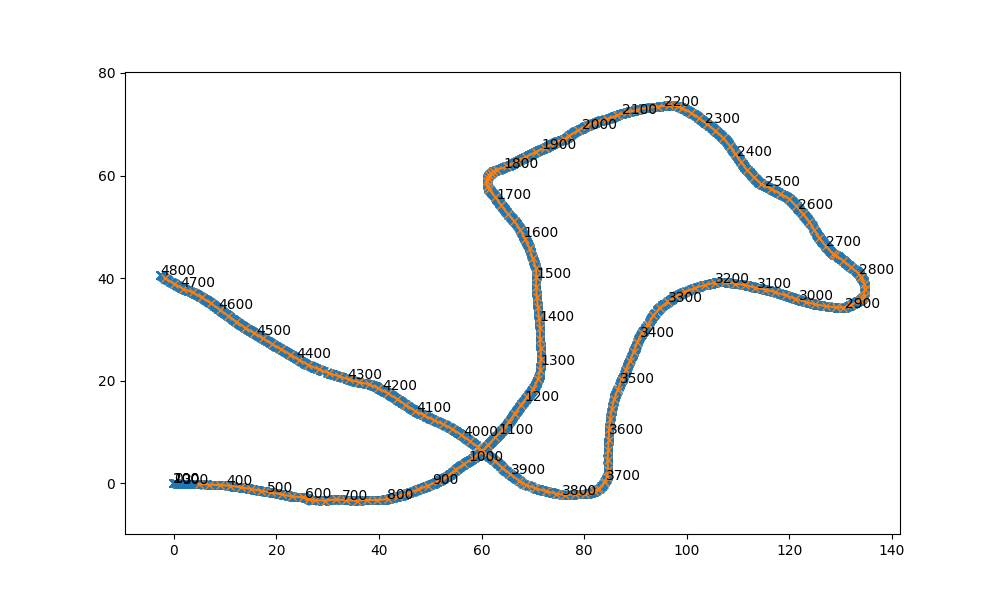

In [8]:
%matplotlib widget
plt.figure(figsize=(10,6))
plt.axis('equal')
plt.plot(poses[:, 0, 3], poses[:,1,3], "-x")
plt.plot(poses_kf[:, 0, 3], poses_kf[:,1,3], "-x")
for i in range(0, poses.shape[0], 100):
    plt.text(poses[i,0,3], poses[i,1,3], str(i))
plt.show()

In [9]:
#df = pd.read_csv("gpsNED.csv")
#df

In [10]:
"""
plt.figure(figsize=(18,10))
plt.scatter(df.iloc[:,0], df.iloc[:,1])
plt.show()
"""

'\nplt.figure(figsize=(18,10))\nplt.scatter(df.iloc[:,0], df.iloc[:,1])\nplt.show()\n'